## Setup

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from scipy.stats import norm
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Import our visualization functions
from plotting_utils import (
    plot_gp_1d, plot_acquisition_1d, plot_bo_iteration_1d,
    plot_2d_function, plot_2d_bo_state, plot_convergence,
    plot_parallel_coordinates
)

# Set random seed for reproducibility
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')


Setup

In [61]:
import os


def collatePreviousSubmissions(functionNo):
    functionIndex = functionNo -1
    assert(functionIndex >= 0)
    assert(functionIndex <= 7)

    #Search for subfolders and find last submission week and results
    week_folders = [d for d in os.listdir("submission_results") if d.startswith("week") ]
    week_folders.sort(key=lambda w: int(w.replace("week", "")))
    last_week = week_folders[-1]
    week_dir = os.path.join("submission_results", last_week)


    def load_file(file_name):
        file_path = os.path.join(week_dir, file_name)
        all_lines = []
        with open(file_path, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                # Parse the trusted Python literals
                parsedData = eval(line, {"array": np.array, "np": np})
                all_lines.append(parsedData)
        return all_lines
    allSubmissions = load_file("inputs.txt")
    allResults = load_file("outputs.txt")

    #Extract the functionNo inputs and outputs only and return those arrays only
    functionSubmissions = np.array([line[functionIndex] for line in allSubmissions])
    functionResults = np.array([line[functionIndex] for line in allResults])

    return functionSubmissions, functionResults


def combineInitialDataAndSubmissionsToDate(functionNo):
    assert(functionNo >= 1)
    assert(functionNo <= 8)

    initialInputs = np.load(f'initial_data/function_{functionNo}/initial_inputs.npy')
    initialOutputs = np.load(f'initial_data/function_{functionNo}/initial_outputs.npy')

    submissions, results = collatePreviousSubmissions(functionNo)

    combined_Inputs = np.vstack((initialInputs, submissions))
    combined_Outputs = np.concatenate((initialOutputs, results))

    assert combined_Inputs.shape[1] == initialInputs.shape[1]
    assert combined_Outputs.shape[0] == combined_Inputs.shape[0]

    return combined_Inputs, combined_Outputs

def lexiSort(arr):
    return arr[np.argsort(arr[:, 2])[::-1]]


[[ 7.310236e-001  7.329999e-001  7.710875e-016]
 [ 6.834182e-001  8.610575e-001  2.535001e-040]
 [ 5.743292e-001  8.798981e-001  1.033078e-046]
 [ 8.838898e-001  5.822540e-001  6.229856e-048]
 [ 3.194039e-001  7.629594e-001  1.322677e-079]
 [ 8.250725e-002  4.034875e-001  3.606771e-081]
 [ 8.403534e-001  2.647316e-001  3.341771e-124]
 [ 3.050000e-002  3.734800e-002  1.733985e-209]
 [ 2.924500e-002  7.675600e-002 -1.187622e-190]
 [ 3.126912e-001  7.872278e-002 -2.089093e-091]
 [ 4.104371e-001  1.475543e-001 -2.159249e-054]
 [ 6.501141e-001  6.815264e-001 -3.606063e-003]]


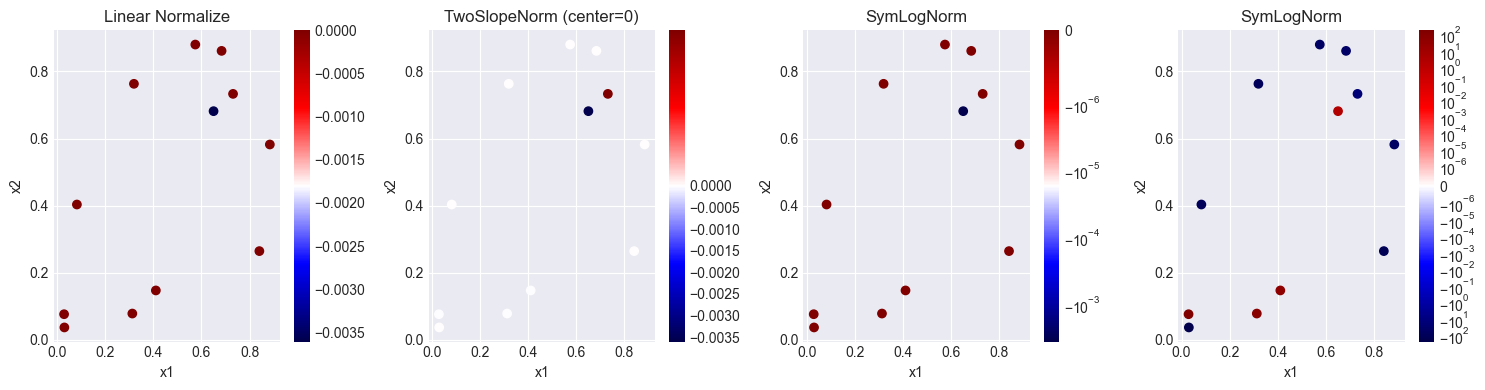

In [63]:
f1_Inputs, f1_Outputs = combineInitialDataAndSubmissionsToDate(1)

f1_inputOutput = np.column_stack((f1_Inputs, f1_Outputs))
f1_inputOutputSorted = lexiSort(f1_inputOutput)

print(np.array2string(f1_inputOutputSorted, floatmode='fixed', precision=6))

x, y, z = np.split(f1_inputOutputSorted, 3, axis=1)


import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, SymLogNorm, Normalize

fig, axes = plt.subplots(1, 4, figsize=(15, 4))

#⃣ Default normalization (linear)
norm1 = Normalize(vmin=z.min(), vmax=z.max())
sc1 = axes[0].scatter(x, y, c=z, cmap="seismic", norm=norm1)
axes[0].set_title("Linear Normalize")
plt.colorbar(sc1, ax=axes[0])

# 2️⃣ TwoSlopeNorm (centered at zero)
norm2 = TwoSlopeNorm(vmin=z.min(), vcenter=0, vmax=z.max())
sc2 = axes[1].scatter(x, y, c=z, cmap="seismic", norm=norm2)
axes[1].set_title("TwoSlopeNorm (center=0)")
plt.colorbar(sc2, ax=axes[1])

# 3️⃣ SymLogNorm (best for huge magnitude differences)
norm3 = SymLogNorm(linthresh=1e-6, vmin=z.min(), vmax=z.max())
sc3 = axes[2].scatter(x, y, c=z, cmap="seismic", norm=norm3)
axes[2].set_title("SymLogNorm")
plt.colorbar(sc3, ax=axes[2])

z_plot = np.sign(z) * np.log10(np.abs(z) + 1e-300)
norm4 = SymLogNorm(linthresh=1e-6, vmin=z_plot.min(), vmax=z_plot.max())
sc4 = axes[3].scatter(x, y, c=z_plot, cmap="seismic", norm=norm4)
axes[3].set_title("SymLogNorm")
plt.colorbar(sc4, ax=axes[3])


for ax in axes:
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

plt.tight_layout()
plt.show()



[[ 0.702637  0.926564  0.611205]
 [ 0.665800  0.123969  0.538996]
 [ 0.877791  0.778628  0.420586]
 [ 0.845275  0.711120  0.293993]
 [ 0.438166  0.685018  0.244619]
 [ 0.454647  0.290455  0.214965]
 [ 0.778688  0.970764  0.093698]
 [ 0.350915  0.117067  0.048338]
 [ 0.341750  0.028698  0.038749]
 [ 0.577713  0.771973  0.023106]
 [ 0.338648  0.213867 -0.013858]
 [ 0.142699  0.349005 -0.065624]]


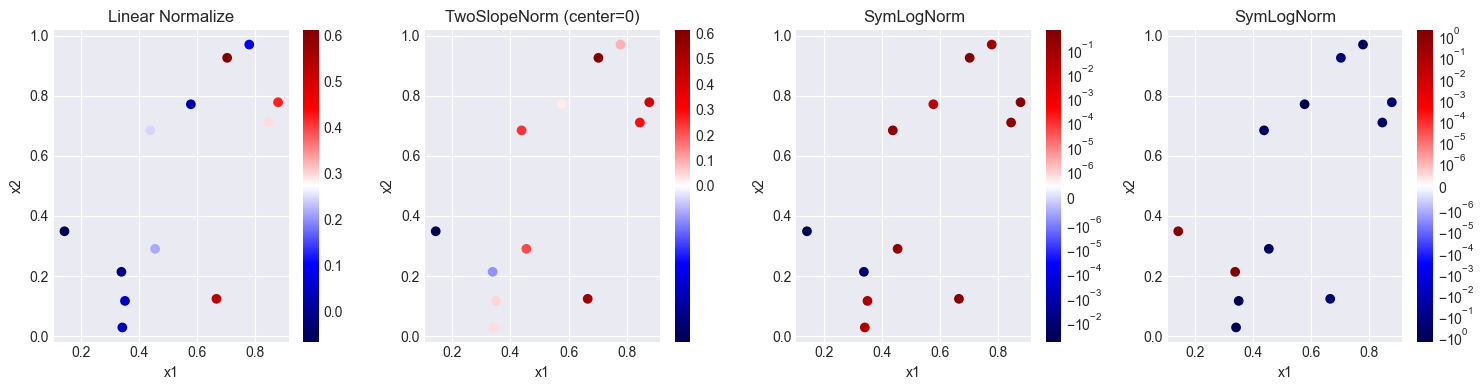

In [64]:
f2_Inputs, f2_Outputs = combineInitialDataAndSubmissionsToDate(2)

f2_inputOutput = np.column_stack((f2_Inputs, f2_Outputs))
f2_inputOutputSorted = lexiSort(f2_inputOutput)

print(np.array2string(f2_inputOutputSorted, floatmode='fixed', precision=6))

x, y, z = np.split(f2_inputOutputSorted, 3, axis=1)

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, SymLogNorm, Normalize

fig, axes = plt.subplots(1, 4, figsize=(15, 4))

#⃣ Default normalization (linear)
norm1 = Normalize(vmin=z.min(), vmax=z.max())
sc1 = axes[0].scatter(x, y, c=z, cmap="seismic", norm=norm1)
axes[0].set_title("Linear Normalize")
plt.colorbar(sc1, ax=axes[0])

# 2️⃣ TwoSlopeNorm (centered at zero)
norm2 = TwoSlopeNorm(vmin=z.min(), vcenter=0, vmax=z.max())
sc2 = axes[1].scatter(x, y, c=z, cmap="seismic", norm=norm2)
axes[1].set_title("TwoSlopeNorm (center=0)")
plt.colorbar(sc2, ax=axes[1])

# 3️⃣ SymLogNorm (best for huge magnitude differences)
norm3 = SymLogNorm(linthresh=1e-6, vmin=z.min(), vmax=z.max())
sc3 = axes[2].scatter(x, y, c=z, cmap="seismic", norm=norm3)
axes[2].set_title("SymLogNorm")
plt.colorbar(sc3, ax=axes[2])

z_plot = np.sign(z) * np.log10(np.abs(z) + 1e-300)
norm4 = SymLogNorm(linthresh=1e-6, vmin=z_plot.min(), vmax=z_plot.max())
sc4 = axes[3].scatter(x, y, c=z_plot, cmap="seismic", norm=norm4)
axes[3].set_title("SymLogNorm")
plt.colorbar(sc4, ax=axes[3])


for ax in axes:
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

plt.tight_layout()
plt.show()